In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import ttest_ind, pearsonr, norm
import pingouin as pg

In [2]:
main_path = r'/Users/dariahasin/Documents/Final project'
path_xls = os.path.join(main_path, 'Merged_networks_table_for_pandas.xls')
path_reading_valus = os.path.join(main_path, 'MRI_TAU_specific_tests_per_subject.xlsx')


subjects_path = os.path.join(main_path, 'subjects')
if not os.path.exists(subjects_path):
    os.mkdir(subjects_path)

df_task1 = pd.read_excel(path_xls, 'Task1')
df_task2 = pd.read_excel(path_xls, 'Task2')
df_reading_valus = pd.read_excel(path_reading_valus)

### Correlation matrix for every subject

In [3]:
def corr_matrix(df_single_network, df_two_network):

    networks = list(df_single_network.columns)
    columns = df_two_network.columns
    subject_df = pd.DataFrame(index=networks, columns=networks)
     
    for column in columns:
        for network1 in networks:
            subject_df[network1][network1] = float(df_single_network[network1])
            for network2 in networks:
                if network1 in column and network2 in column and network1 != network2:
                    subject_df[network1][network2] = float(df_two_network[column])

    return subject_df

/Users/dariahasin/opt/miniconda3/envs/bm-336546/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


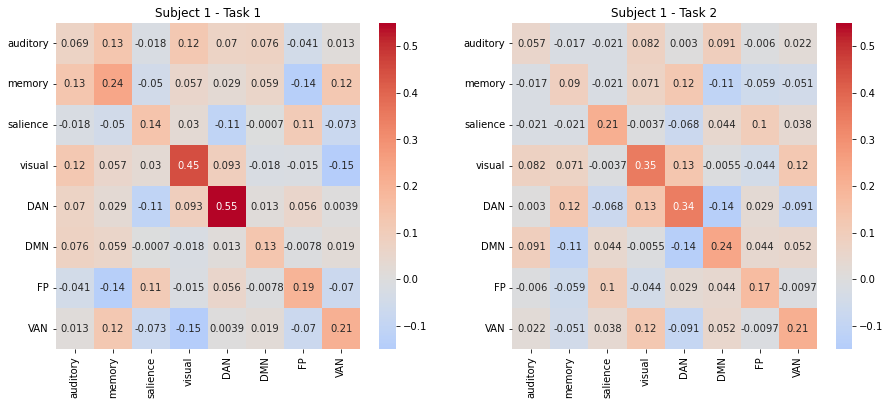

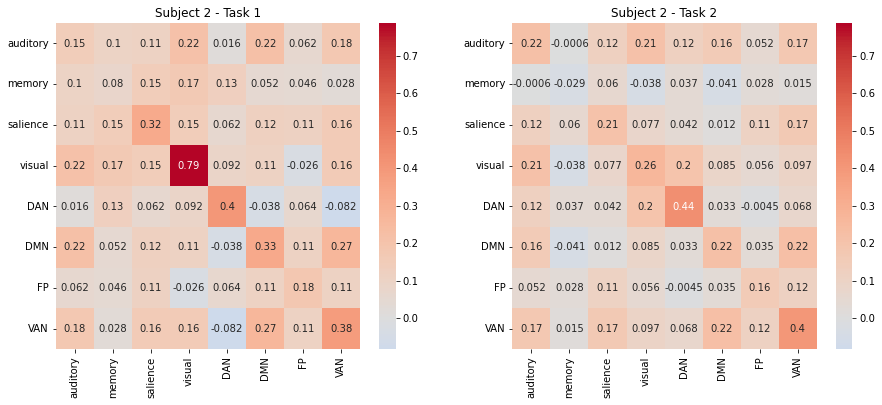

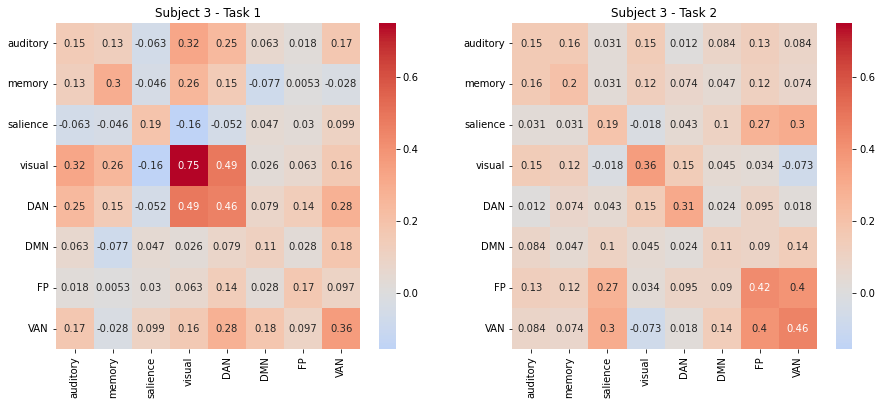

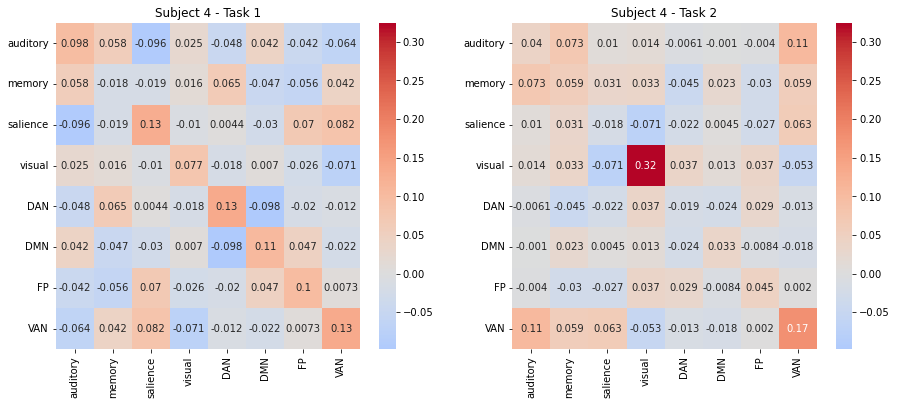

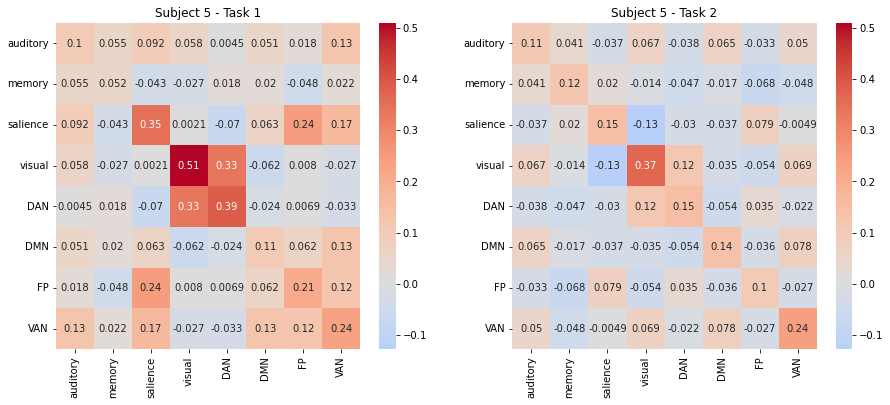

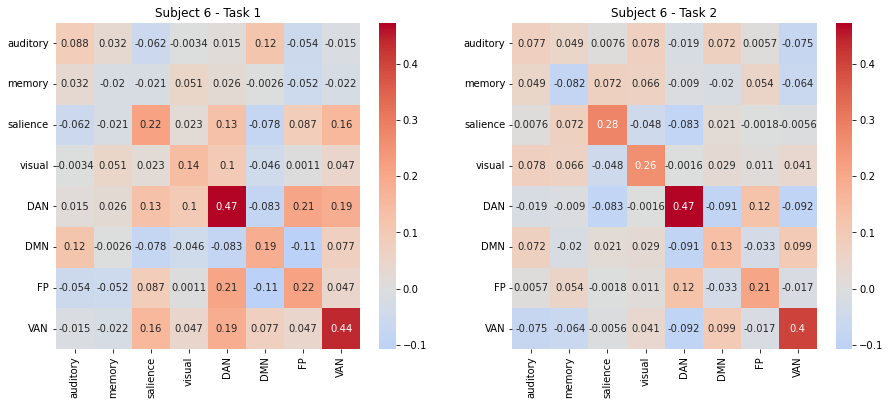

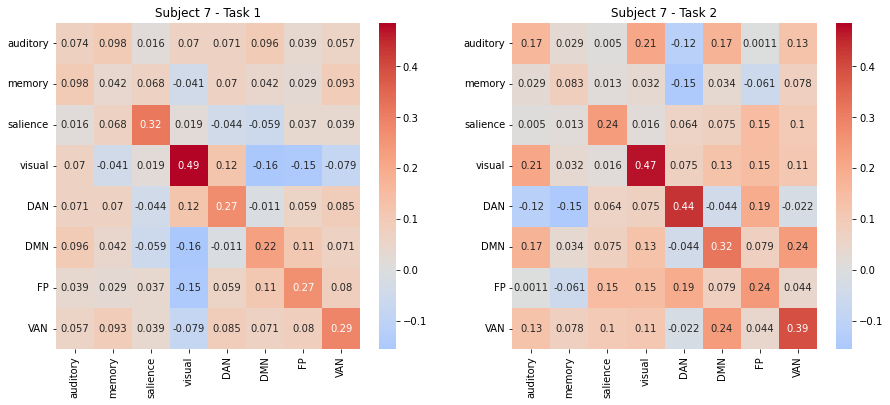

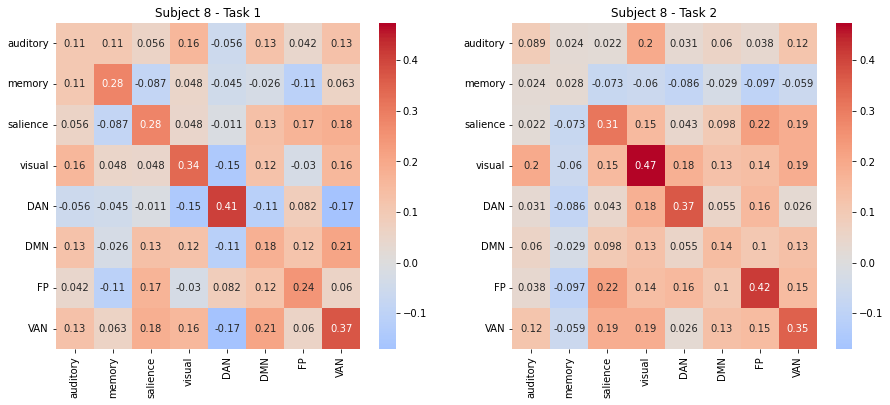

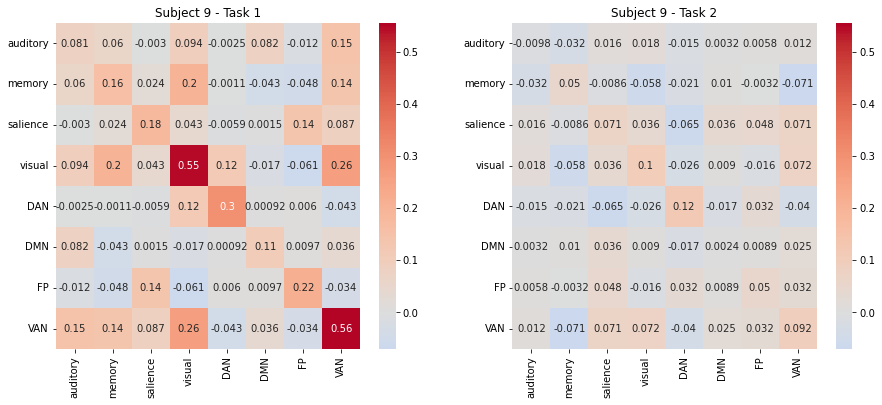

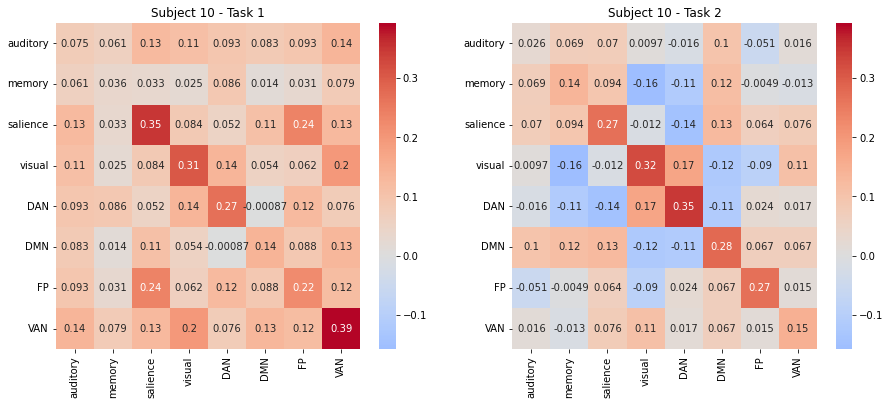

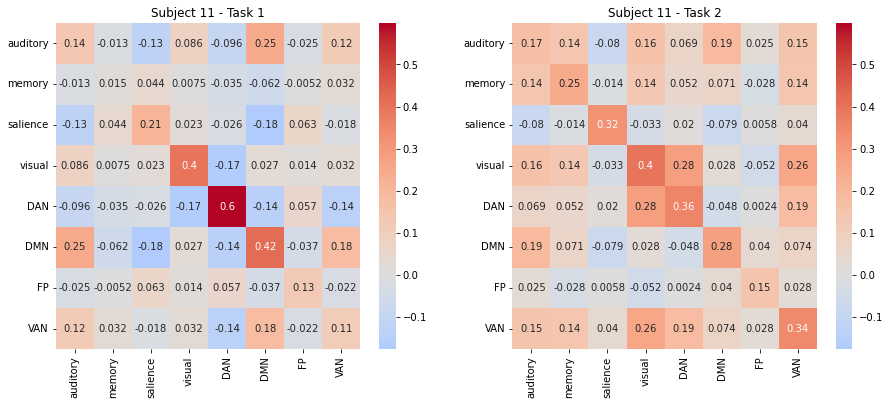

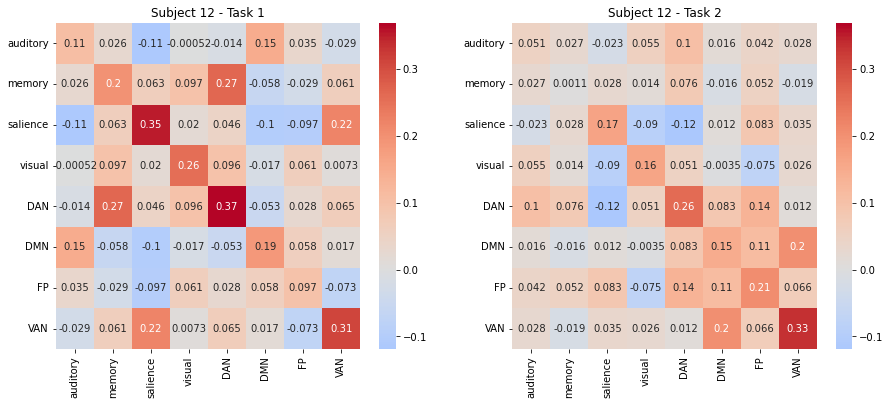

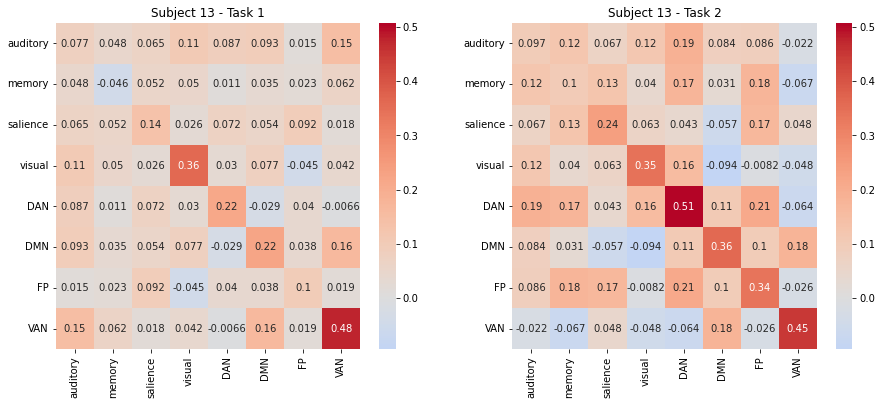

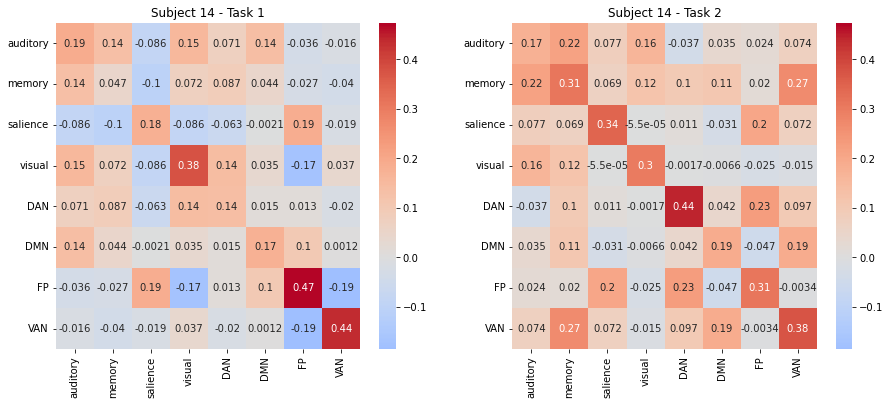

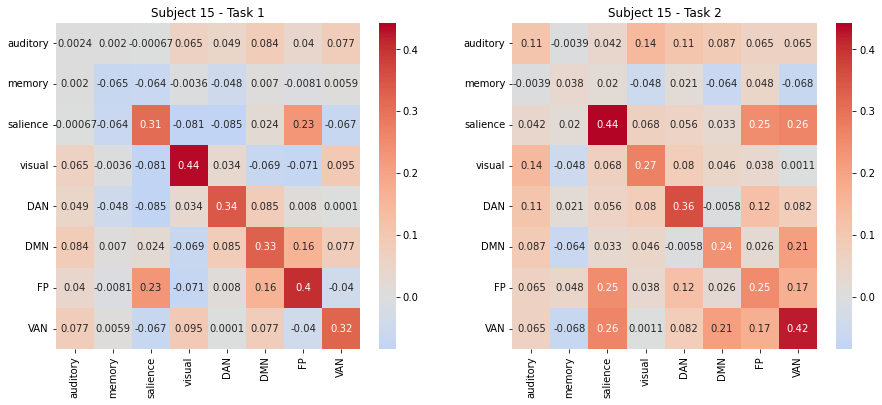

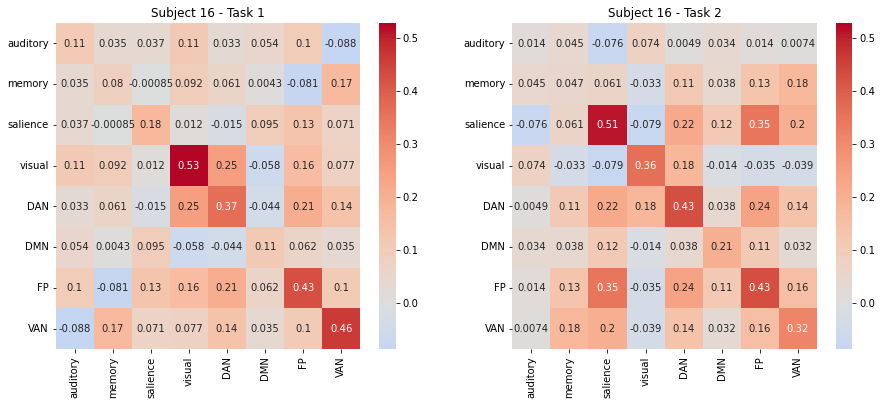

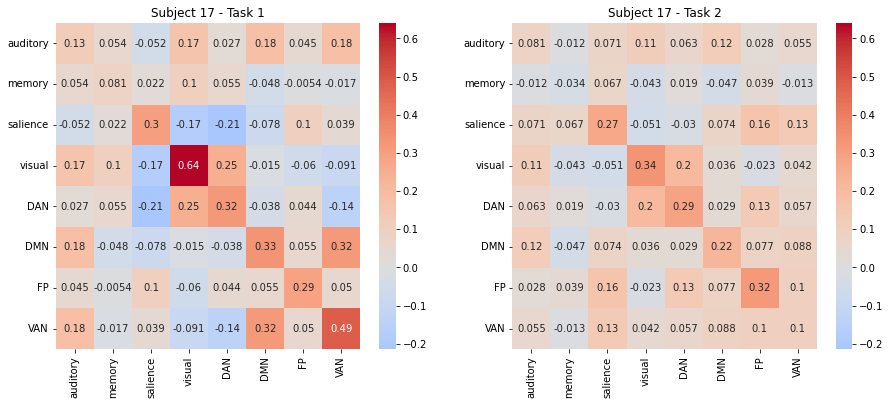

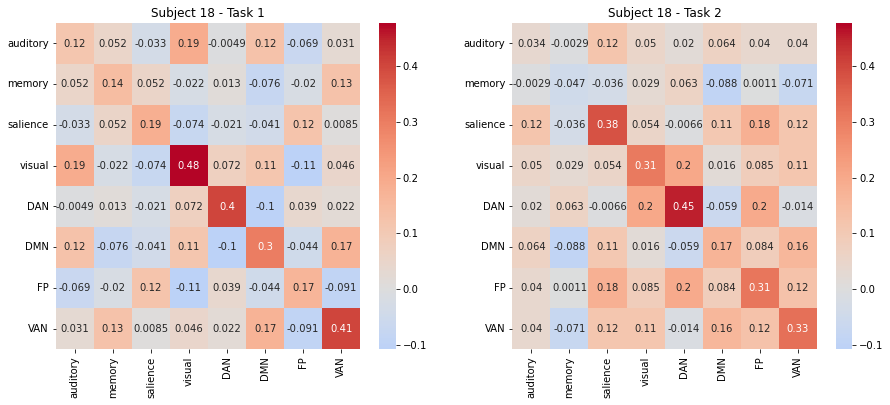

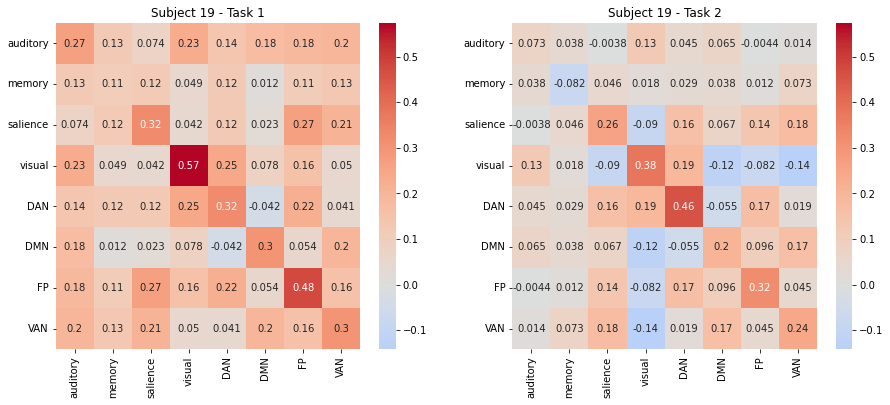

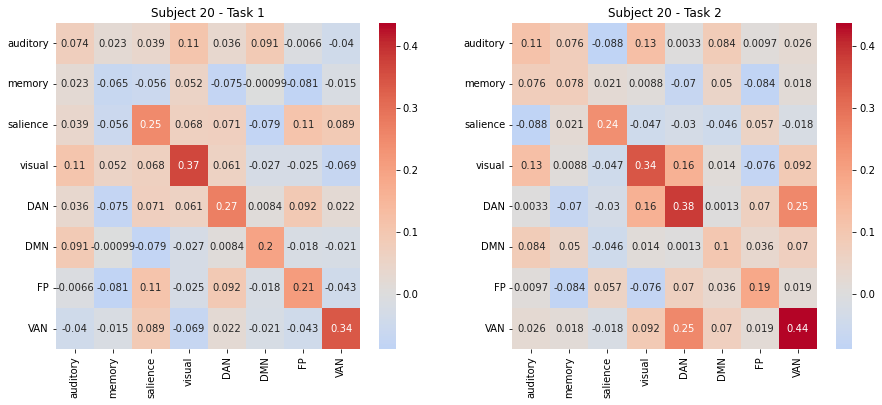

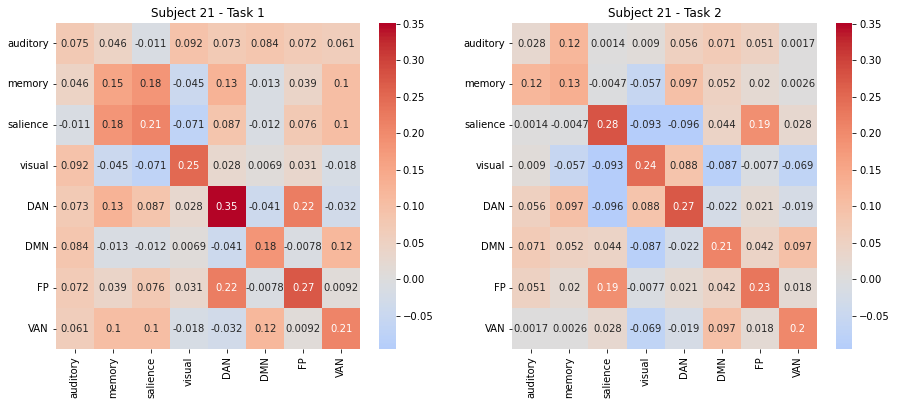

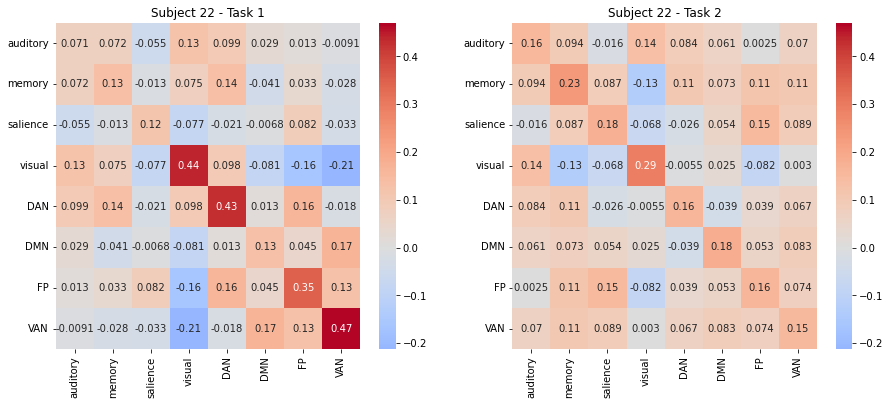

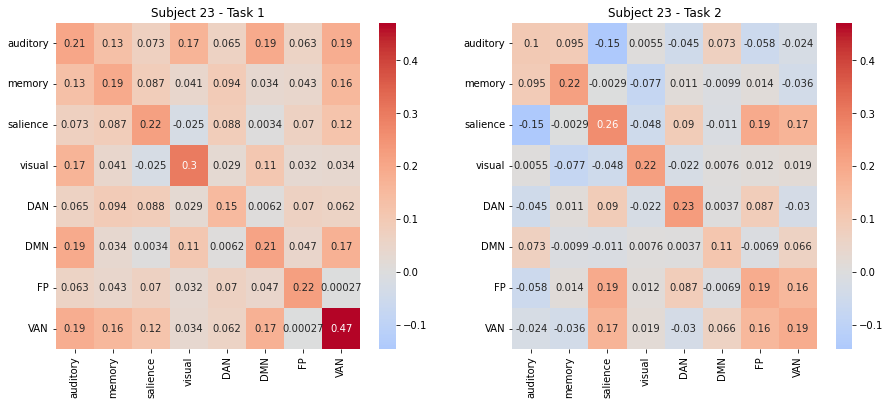

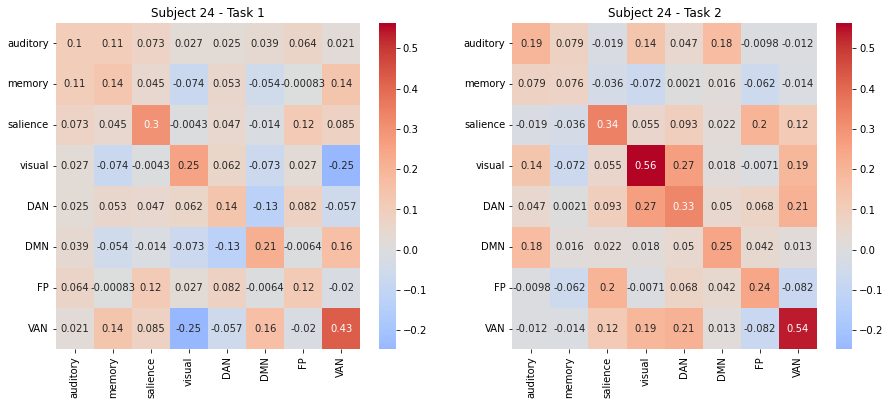

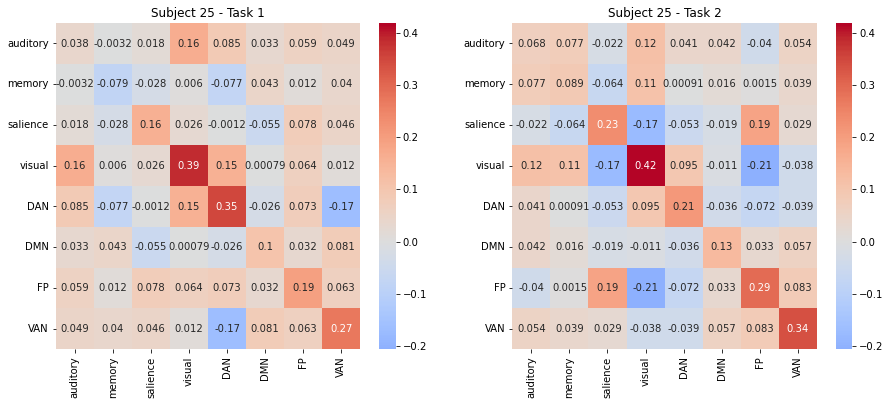

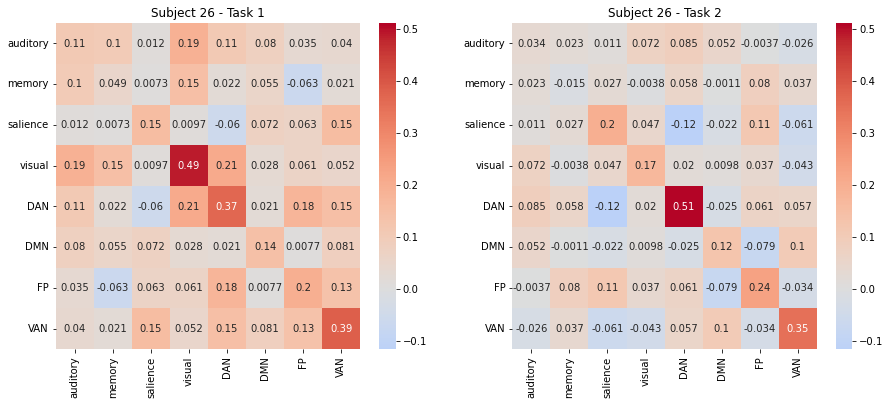

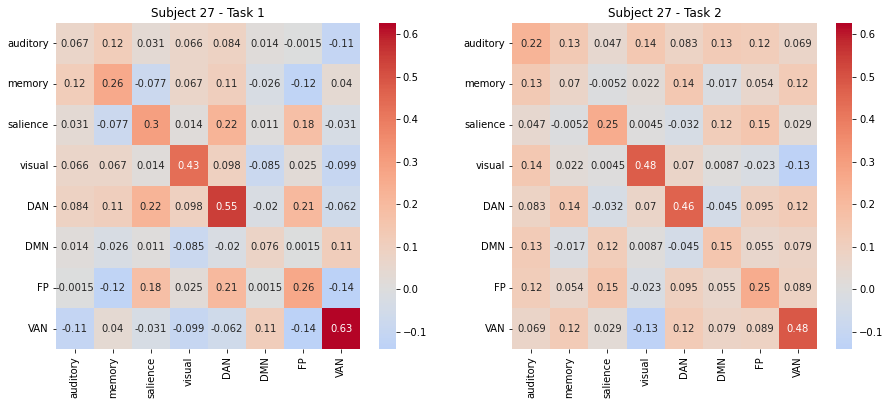

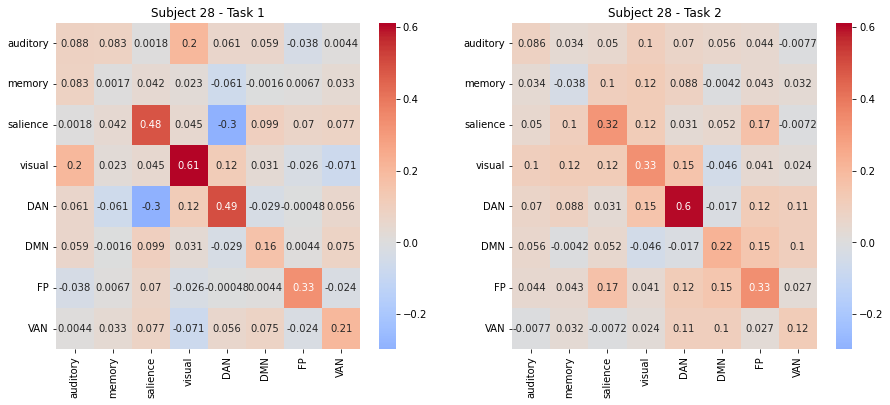

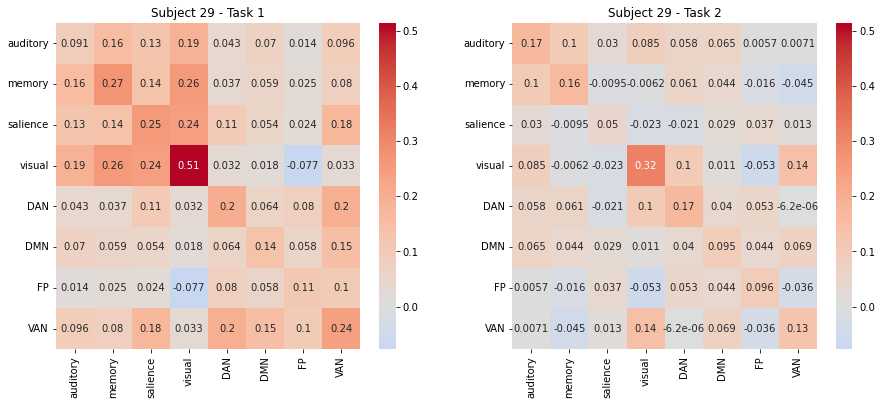

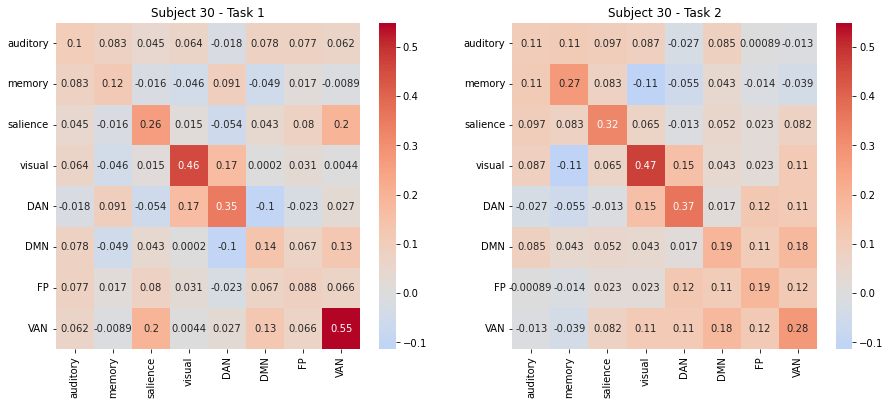

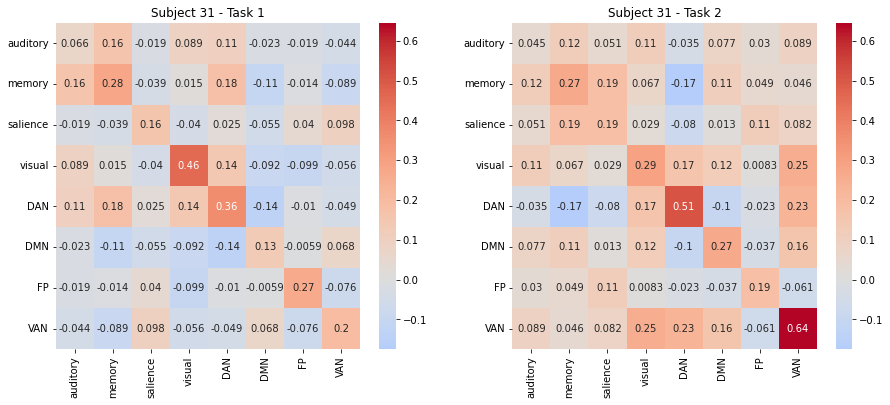

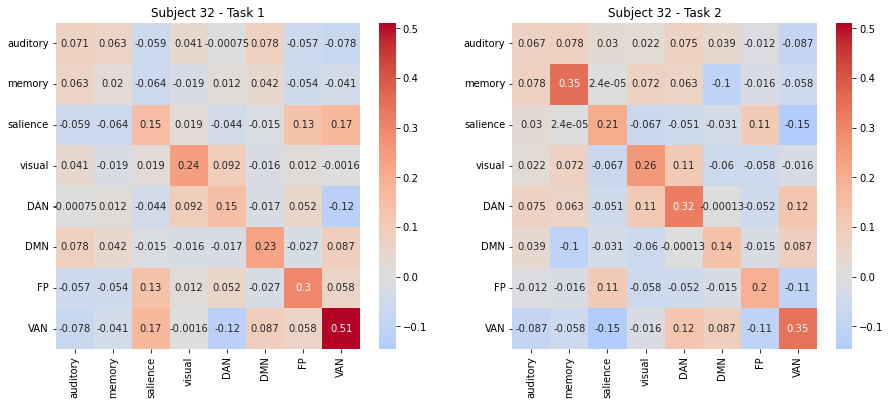

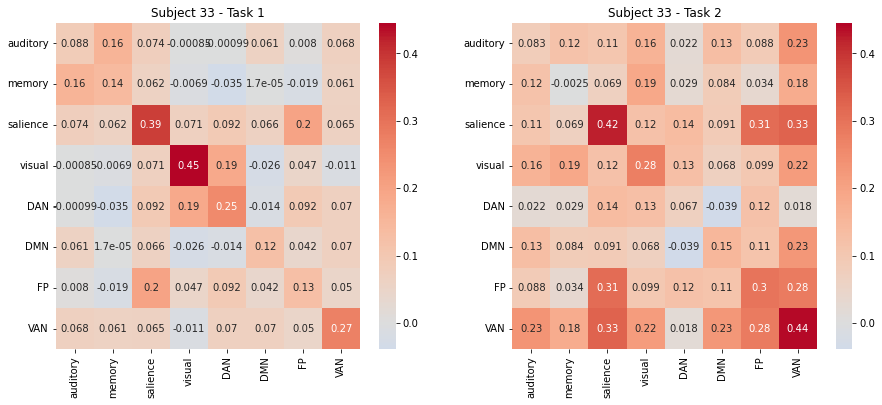

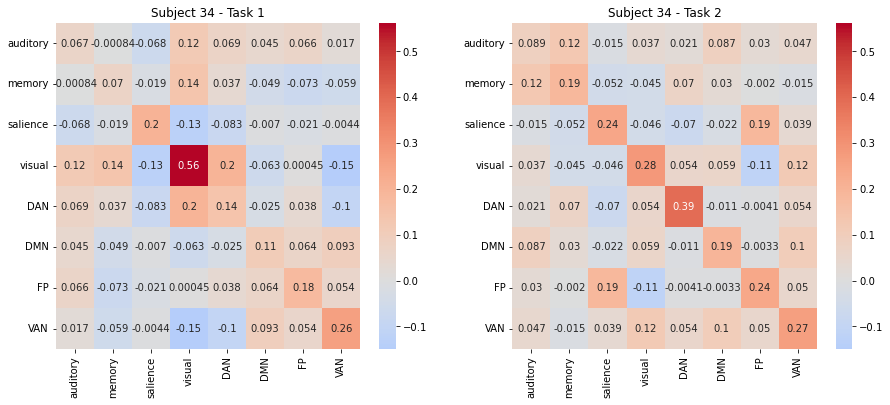

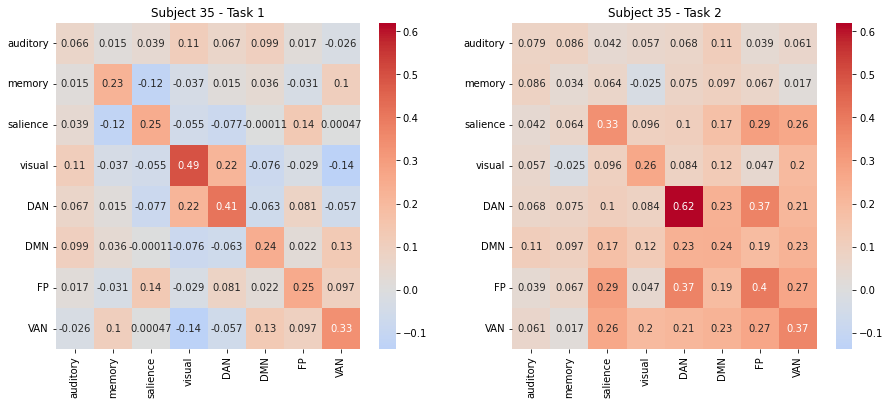

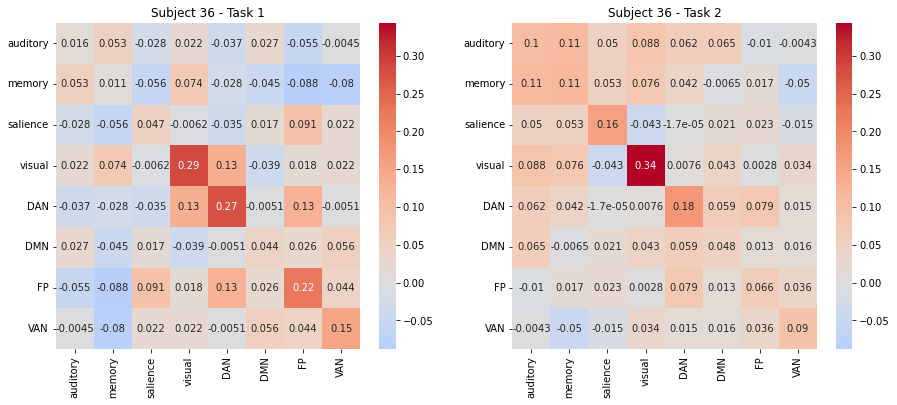

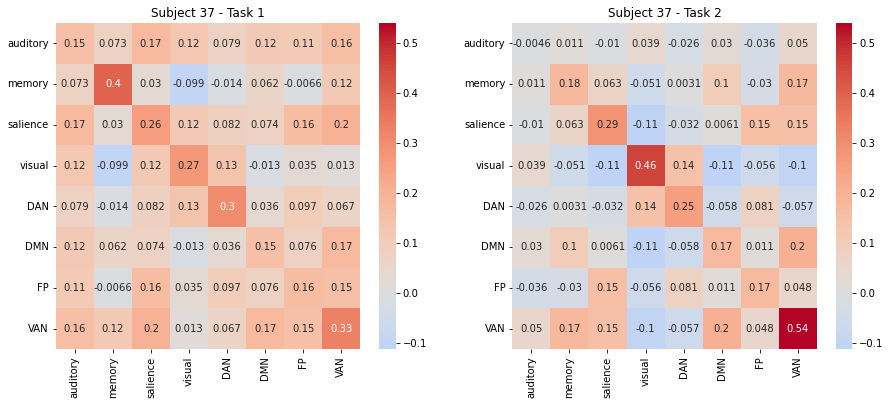

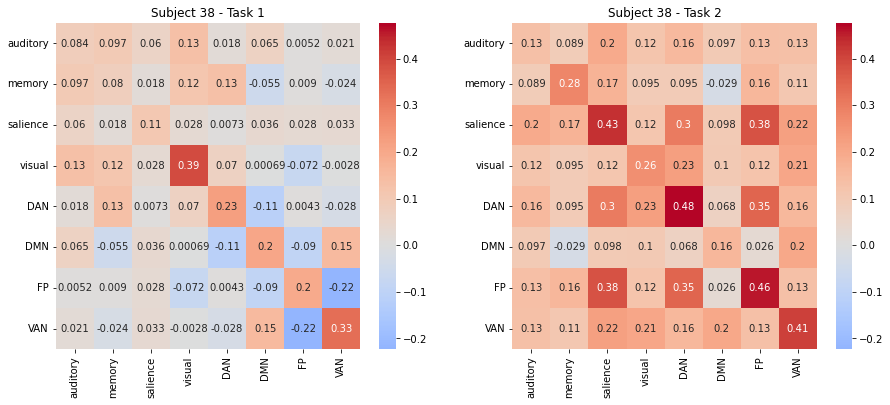

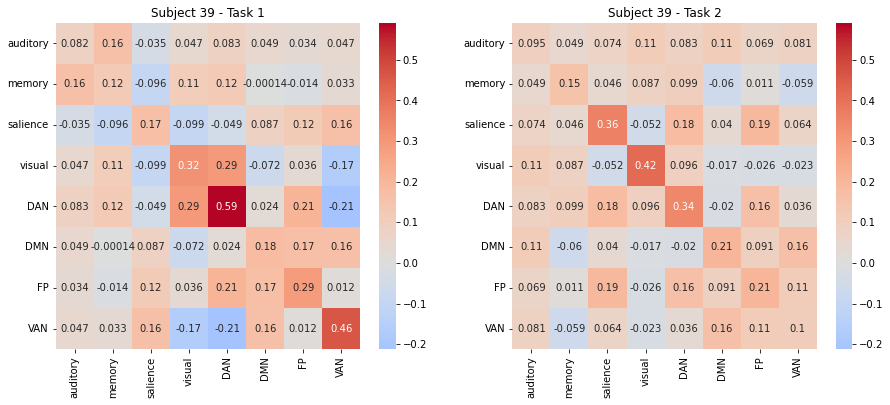

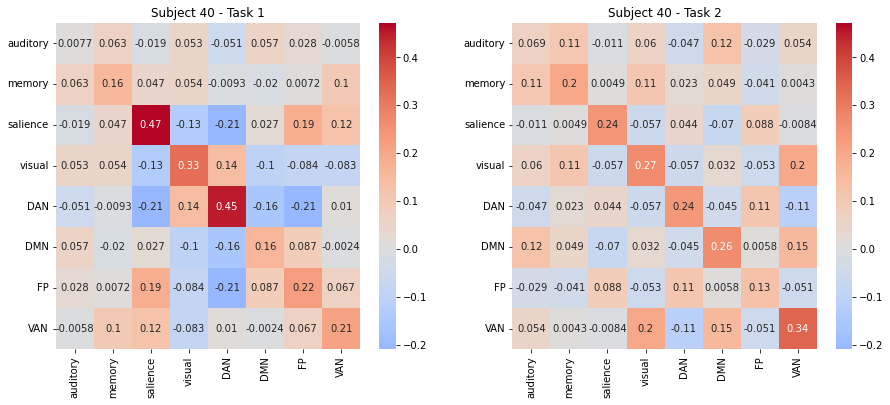

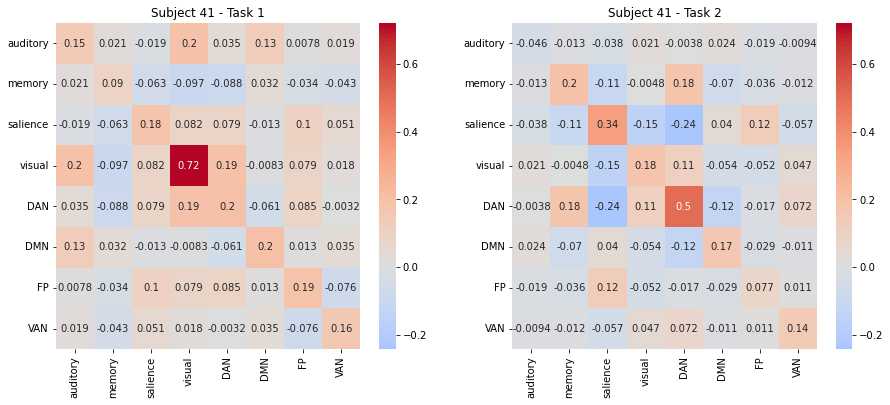

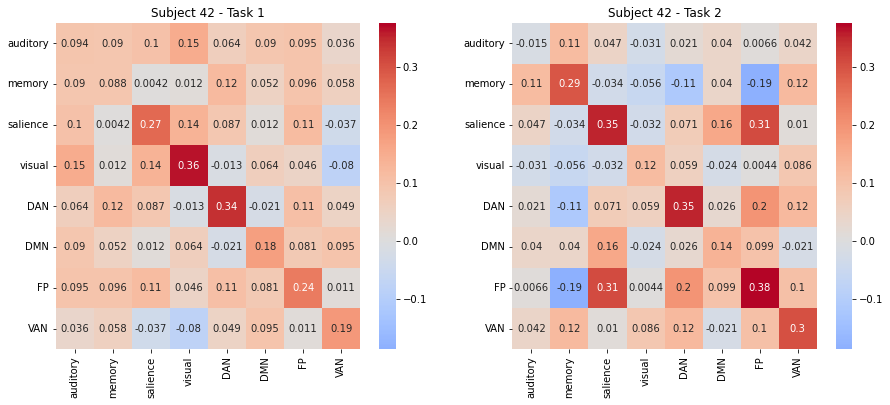

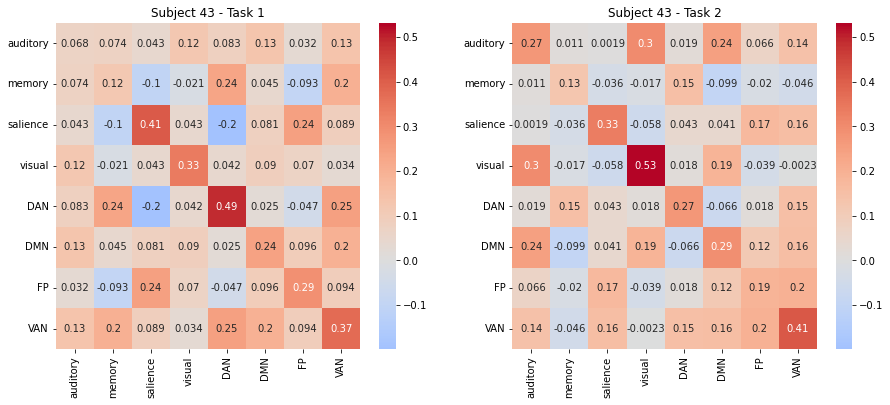

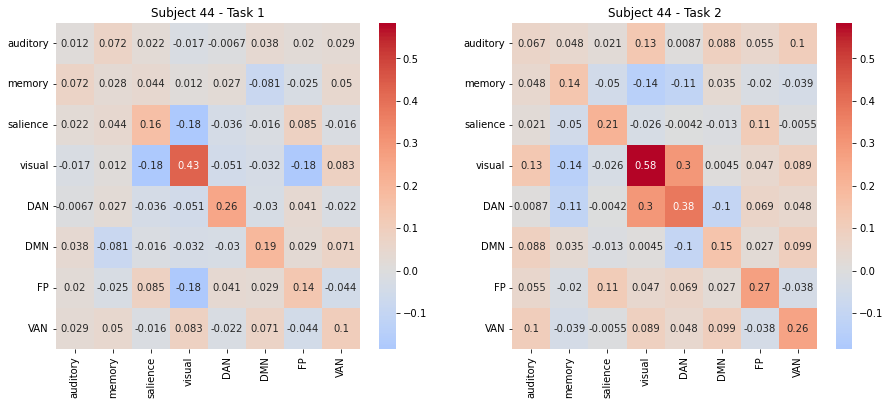

In [4]:
num_of_subjects = 44
heatmaps_path =  os.path.join(subjects_path, 'subjects_heatmaps')
if not os.path.exists(heatmaps_path):
    os.mkdir(heatmaps_path)
    
for i in range(num_of_subjects):
    subject_path = os.path.join(subjects_path, f'subject_{i+1}')
    if not os.path.exists(subject_path):
        os.mkdir(subject_path)
    
    one_subject_task1 = df_task1.iloc[i:i+1, 1:]
    one_subject_task2 = df_task2.iloc[i:i+1, 1:]
    
    
    df_no_pictures_single_network = one_subject_task1.iloc[:, :8]
    df_no_pictures_two_network = one_subject_task1.iloc[:, 8:]
    subject_df_no_pictures = corr_matrix(df_no_pictures_single_network, df_no_pictures_two_network)

    df_with_pictures_single_network = one_subject_task2.iloc[:, :8]
    df_with_pictures_two_network = one_subject_task2.iloc[:, 8:]
    subject_df_with_pictures = corr_matrix(df_with_pictures_single_network, df_with_pictures_two_network)
    
#     subject_df_no_pictures.to_excel(os.path.join(subject_path, 'Task1_corr_matrix.xlsx'))
#     subject_df_with_pictures.to_excel(os.path.join(subject_path, 'Task2_corr_matrix.xlsx'))

    networks = list(subject_df_no_pictures.columns)
    vmax = np.max([np.max(subject_df_no_pictures), np.max(subject_df_with_pictures)])
    vmin = np.min([np.min(subject_df_no_pictures), np.min(subject_df_with_pictures)])
    
    fig = plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.heatmap(subject_df_no_pictures.to_numpy(dtype='float64'), xticklabels=networks, yticklabels=networks, annot=True, vmax=vmax, vmin=vmin, center=0, cmap='coolwarm')
    plt.title(f'Subject {i+1} - Task 1')
    
    plt.subplot(1,2,2)
    sns.heatmap(subject_df_with_pictures.to_numpy(dtype='float64'), xticklabels=networks, yticklabels=networks, annot=True, vmax=vmax, vmin=vmin, center=0, cmap='coolwarm')
    plt.title(f'Subject {i+1} - Task 2')
    plt.savefig(os.path.join(heatmaps_path, f'subject{i+1}_heatmaps.jpeg'))

### Distance between the correlations between two tasks

In [3]:
def list_dir(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [1]:
# subjects_path = os.path.join(main_path, 'subjects')
# distance_dict = {}
# for subject_path in list_dir(subjects_path):
#     if os.path.basename(subject_path).startswith('subject'):
#         task1_dir = os.path.join(subject_path, 'Task1_corr_matrix.xlsx')
#         task2_dir = os.path.join(subject_path, 'Task2_corr_matrix.xlsx')

#         task1_arr = pd.read_excel(task1_dir).iloc[:, 1:].to_numpy(dtype=float)
#         task2_arr = pd.read_excel(task2_dir).iloc[:, 1:].to_numpy(dtype=float)

#         distance = np.sqrt(np.sum((task1_arr - task2_arr)**2))
#         print(task1_arr - task2_arr)
#         print((task1_arr - task2_arr)**2)
#         break
#         distance_dict[f'{os.path.basename(subject_path)}'] = distance

# # df_distance = pd.DataFrame.from_dict(distance_dict, orient='index', columns=['distance'])
# # df_distance.to_excel(os.path.join(main_path, 'distance_between_tasks.xlsx'))

### T-test

In [5]:
df_task1_values = df_task1.iloc[:44, 1:]
df_task2_values = df_task2.iloc[:44, 1:]
columns = df_task1_values.columns
vals = {}

for column in columns:
    one_column_task1 = df_task1_values.loc[:, column].to_numpy()
    one_column_task2 = df_task2_values.loc[:, column].to_numpy()
    
    t_score, p_value = ttest_ind(one_column_task1, one_column_task2)
    mean_diff = np.mean(one_column_task1) - np.mean(one_column_task2)
    std_diff = np.std(one_column_task1) - np.std(one_column_task2)
    
    vals[column] = [t_score, p_value, mean_diff, std_diff]

df_vals = pd.DataFrame.from_dict(vals, orient='index', columns=['t_score', 'p_value', 'mean_diff', 'std_diff'])
df_vals.to_excel(os.path.join(main_path, 't_test_values_dys.xlsx'))

### Fisher z-transformation

In [9]:
subjects_path = os.path.join(main_path, 'subjects')
z_dict = {}
for subject_path in list_dir(subjects_path):
    if os.path.basename(subject_path).startswith('subject'):
        task1_dir = os.path.join(subject_path, 'Task1_corr_matrix.xlsx')
        task2_dir = os.path.join(subject_path, 'Task2_corr_matrix.xlsx')

        task1_arr = pd.read_excel(task1_dir).iloc[:, 1:].to_numpy(dtype=float)
        task2_arr = pd.read_excel(task2_dir).iloc[:, 1:].to_numpy(dtype=float)
        
        r, p = pearsonr(task1_arr.flatten(), task2_arr.flatten())
        r_z = np.arctanh(r)
        z_dict[f'{os.path.basename(subject_path)}'] = {'r': r, 'p_value': p, 'r_z': r_z}

df_z = pd.DataFrame.from_dict(z_dict, orient='index', columns=['r', 'p_value', 'r_z'])
df_z.to_excel(os.path.join(main_path, 'z_between_tasks.xlsx'))

r       p_value       r_z
subject_12  0.392788  1.325216e-03  0.415093
subject_15  0.622795  3.904607e-08  0.729559
subject_23  0.492958  3.498843e-05  0.539961
subject_24  0.472437  8.094450e-05  0.513203
subject_41  0.379178  2.002174e-03  0.399099
subject_25  0.650521  5.945760e-09  0.776202
subject_22  0.594834  2.181525e-07  0.685114
subject_14  0.551838  2.283329e-06  0.621020
subject_13  0.591207  2.694924e-07  0.679519
subject_40  0.439105  2.836058e-04  0.471122
subject_4   0.272741  2.922447e-02  0.279823
subject_3   0.406971  8.458979e-04  0.431976
subject_2   0.657671  3.545560e-09  0.788698
subject_5   0.746368  1.453182e-12  0.964705
subject_31  0.438575  2.890227e-04  0.470465
subject_36  0.608505  9.603989e-08  0.706544
subject_38  0.433316  3.481184e-04  0.463972
subject_39  0.611612  7.927318e-08  0.711492
subject_37  0.734801  4.782660e-12  0.939084
subject_30  0.742895  2.091886e-12  0.956910
subject_42  0.373139  2.391270e-03  0.392064
subject_29  0.406959  8.462347e-04  0.431961
subject_16  0.627798  2.818581e-08  0.737774
subject_11  0.538895  4.349980e-06  0.602597
subject_18  0.576500  6.186452e-07  0.657204
subject_27  0.730023  7.684912e-12  0.928776
subject_20  0.705479  7.563829e-11  0.878126
subject_43  0.662705  2.443168e-09  0.797622
subject_44  0.598360  1.771946e-07  0.690589
subject_21  0.665526  1.976942e-09  0.802668
subject_19  0.759767  3.366577e-13  0.995664
subject_26  0.623428  3.748046e-08  0.730594
subject_10  0.635870  1.645478e-08  0.751210
subject_28  0.739054  3.109141e-12  0.948391
subject_17  0.713086  3.819113e-11  0.893435
subject_7   0.488379  4.238686e-05  0.533930
subject_9   0.487424  4.410245e-05  0.532676
subject_8   0.675211  9.388086e-10  0.820260
subject_6   0.670172  1.387840e-09  0.811056
subject_1   0.640325  1.214400e-08  0.758724
subject_35  0.477397  6.641326e-05  0.519608
subject_32  0.495735  3.110494e-05  0.543636
subject_33  0.513526  1.427861e-05  0.567508
subject_34  0.509523  1.707749e-05  0.562086

### Correlation between networks and reading ability

In [19]:
def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='zou'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

In [38]:
n = 44
columns = df_task1.iloc[:, 1:-2].columns
partial_corr_dict = {}

for column in columns:
    p_corr_t1 = pg.partial_corr(data=df_task1, x='Child_WordReading_exact_SD_accuracy', y=column, covar='Conners_Self_T_score').round(3)
    p_corr_t2 = pg.partial_corr(data=df_task2, x='Child_WordReading_exact_SD_accuracy', y=column, covar='Conners_Self_T_score').round(3)
    
    r_t1 = float(p_corr_t1['r'])
    r_t2 = float(p_corr_t2['r'])
    
    z = ((r_t1-r_t2)/np.sqrt(2/(n - 3))).round(3)
    p = (1 - norm.cdf(z)).round(3)
    partial_corr_dict[column] = {'r_test1':r_t1, 'r_test2':r_t2, 'test_statistic_z':z, 'p_value':p}

partial_corr_df = pd.DataFrame.from_dict(partial_corr_dict, orient='index', columns=['r_test1', 'r_test2', 'test_statistic_z', 'p_value'])
partial_corr_df.to_excel(os.path.join(main_path, 'partial_corr_df.xlsx'))
partial_corr_df

r_test1  r_test2  test_statistic_z  p_value
auditory            -0.027   -0.036             0.041    0.484
memory               0.247    0.085             0.733    0.232
salience             0.121    0.158            -0.168    0.567
visual              -0.011   -0.074             0.285    0.388
DAN                  0.091   -0.055             0.661    0.254
DMN                 -0.090   -0.000            -0.407    0.658
FP                   0.017   -0.044             0.276    0.391
VAN                  0.216   -0.024             1.087    0.139
auditory-memory      0.223   -0.148             1.680    0.046
auditory-salience    0.301    0.116             0.838    0.201
auditory-visual      0.060   -0.068             0.580    0.281
auditory-DAN        -0.052   -0.230             0.806    0.210
DAN-DMN             -0.037   -0.028            -0.041    0.516
DAN-memory          -0.057   -0.161             0.471    0.319
DAN_salience         0.122   -0.032             0.697    0.243
DAN_visual          -0.051   -0.106             0.249    0.402
DMN_auditory        -0.021    0.054            -0.340    0.633
DMN_memory           0.291   -0.210             2.268    0.012
DMN_salience         0.117    0.380            -1.191    0.883
DMN_visual           0.018    0.192            -0.788    0.785
FP_auditory         -0.038   -0.143             0.475    0.317
FP_DAN              -0.033   -0.018            -0.068    0.527
FP_DMN               0.087    0.084             0.014    0.494
FP_memory           -0.071   -0.290             0.992    0.161
FP_salience          0.173    0.118             0.249    0.402
FP_VAN              -0.129    0.146            -1.245    0.893
FP_visual            0.086    0.124            -0.172    0.568
memory_salience     -0.181   -0.048            -0.602    0.726
memory_visual       -0.208   -0.009            -0.901    0.816
VAN_auditory         0.032    0.020             0.054    0.478
VAN_DAN             -0.162    0.038            -0.906    0.818
VAN_DMN              0.104   -0.092             0.887    0.188
VAN_memory           0.114   -0.093             0.937    0.174
VAN_salience         0.031    0.105            -0.335    0.631
VAN_visual          -0.042    0.208            -1.132    0.871
visual_salience      0.400    0.131             1.218    0.112

In [32]:
n = 44
columns = df_task1.iloc[:, 1:-2].columns
corr_dict = {}



for column in columns:
    p_corr_t1 = pg.corr(x=df_task1['Child_WordReading_exact_SD_accuracy'].to_numpy(), y=df_task1[column].to_numpy()).round(3)
    p_corr_t2 = pg.corr(x=df_task2['Child_WordReading_exact_SD_accuracy'].to_numpy(), y=df_task2[column].to_numpy()).round(3)
    
    r_t1 = float(p_corr_t1['r'])
    r_t2 = float(p_corr_t2['r'])
    
    z = ((r_t1-r_t2)/np.sqrt(2/(n - 3))).round(3)
    p = (1 - norm.cdf(z)).round(3)
    corr_dict[column] = {'r_test1':r_t1, 'r_test2':r_t2, 'test_statistic_z':z, 'p_value':p}

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['r_test1', 'r_test2', 'test_statistic_z', 'p_value'])
corr_df

r_test1  r_test2  test_statistic_z  p_value
auditory            -0.029   -0.022            -0.032    0.513
memory               0.190    0.086             0.471    0.319
salience             0.110    0.235            -0.566    0.714
visual              -0.040   -0.121             0.367    0.357
DAN                  0.072   -0.087             0.720    0.236
DMN                 -0.087   -0.038            -0.222    0.588
FP                  -0.033    0.011            -0.199    0.579
VAN                  0.231    0.030             0.910    0.181
auditory-memory      0.175   -0.180             1.607    0.054
auditory-salience    0.306    0.113             0.874    0.191
auditory-visual      0.089   -0.035             0.561    0.287
auditory-DAN        -0.106   -0.099            -0.032    0.513
DAN-DMN              0.025    0.026            -0.005    0.502
DAN-memory          -0.137   -0.016            -0.548    0.708
DAN_salience         0.069    0.001             0.308    0.379
DAN_visual          -0.070   -0.083             0.059    0.476
DMN_auditory         0.039    0.041            -0.009    0.504
DMN_memory           0.353   -0.297             2.943    0.002
DMN_salience         0.203    0.307            -0.471    0.681
DMN_visual           0.142    0.156            -0.063    0.525
FP_auditory         -0.132   -0.119            -0.059    0.524
FP_DAN              -0.080   -0.008            -0.326    0.628
FP_DMN               0.072    0.054             0.081    0.468
FP_memory           -0.193   -0.255             0.281    0.389
FP_salience          0.215    0.200             0.068    0.473
FP_VAN              -0.179    0.172            -1.589    0.944
FP_visual            0.139    0.090             0.222    0.412
memory_salience     -0.262   -0.079            -0.829    0.796
memory_visual       -0.148    0.084            -1.050    0.853
VAN_auditory         0.033    0.041            -0.036    0.514
VAN_DAN             -0.127    0.040            -0.756    0.775
VAN_DMN              0.083   -0.139             1.005    0.157
VAN_memory           0.122   -0.048             0.770    0.221
VAN_salience        -0.012    0.109            -0.548    0.708
VAN_visual           0.035    0.213            -0.806    0.790
visual_salience      0.444    0.153             1.318    0.094